# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info 

import sklearn

import tensorflow as tf
from tensorflow import keras


import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")
    
def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_3.png?raw=true" alt="Figure 14-3" width=500>

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_4.png?raw=true" alt="Figure 14-4" width=500>

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_5.png?raw=true" alt="Figure 14-5" width=500>



In TensorFlow, each input image is typically represented as a 3D tensor of shape `[height, width, channels]`. A mini-batch is represented as a 4D tensor of shape `[mini-batch size, height, width, channels]`. The weights of a convolutional layer are represented as a 4D tensor of shape `[fh, fw, fn', fn]`. The bias terms of a convolutional layer are simply represented as a 1D tensor of shape `[fn]`.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_7.png?raw=true" alt="Figure 14-7" width=500>

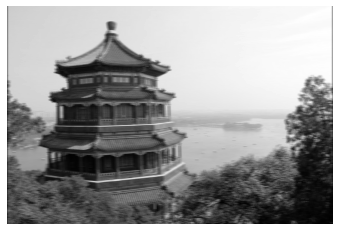

In [3]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255 # (427, 640, 3)
flower = load_sample_image("flower.jpg") /255 # (427, 640, 3)
images = np.array([china, flower]) # (2, 427, 640, 3)
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

In [4]:
china.shape, flower.shape, images.shape, outputs.shape

((427, 640, 3), (427, 640, 3), (2, 427, 640, 3), TensorShape([2, 427, 640, 2]))

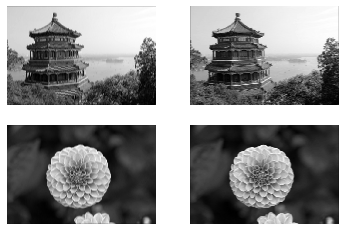

In [5]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [6]:
def crop(images):
    return images[150:220, 130:250]

Saving figure china_original


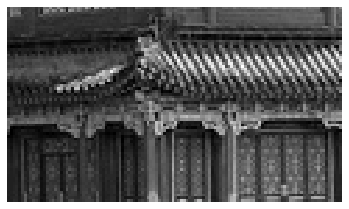

Saving figure china_vertical


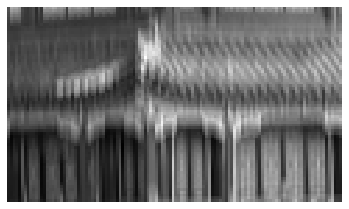

Saving figure china_horizontal


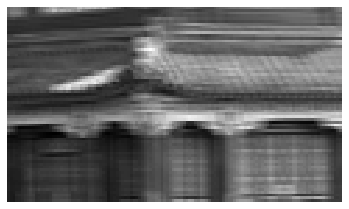

In [7]:
plot_image(crop(images[0, :, :, 0]))
save_fig("china_original", tight_layout=False)
plt.show()

for feature_map_index, filename in enumerate(["china_vertical", "china_horizontal"]):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    save_fig(filename, tight_layout=False)
    plt.show()

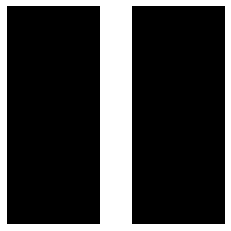

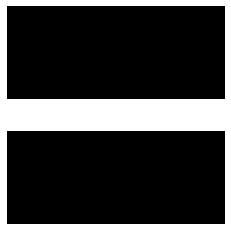

In [8]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show();

## Convolutional Layer
Using `keras.layers.Conv2D()`:

In [9]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, 
                           padding="SAME", activation="relu")

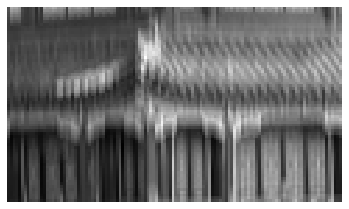

In [10]:
plot_image(crop(outputs[0, :, :, 0]))
plt.show()

## VALID vs SAME padding

In [11]:
def feature_map_size(input_size, kernal_size, strides=1, padding="SAME"):
    # 1-D size calculation
        if padding == "SAME":
                return (input_size -1) // strides +1
        else: 
            return (input_size - kernel_size) // strides + 1

In [12]:
def pad_before_and_padded_size(input_size, kernel_size, strides=1):
    fmap_size = feature_map_size(input_size, kernel_size, strides)
    padded_size = max((fmap_size -1) * strides + kernel_size, input_size)
    pad_before = (padded_size - input_size) // 2
    return pad_before, padded_size

In [13]:
def manual_same_padding(images, kernel_size, strides=1):
    if kernel_size == 1:
        return images.astype(np.float32)
    batch_size, height, width, channels = images.shape
    top_pad, padded_height = pad_before_and_padded_size(height, kernel_size, strides)
    left_pad, padded_width = pad_before_and_padded_size(width, kernel_size, strides)
    padded_shape = [batch_size, padded_height, padded_width, channels]
    padded_images = np.zeros(padded_shape, dtype=np.float32)
    padded_images[:, top_pad:height+top_pad, left_pad:width+left_pad, :] = images
    return padded_images

Using `"SAME"` padding is equivalent to padding manually using `manual_same_padding()` then using `"VALID"` padding (confusingly, `"VALID"` padding means no padding at all):

In [14]:
kernel_size = 7
strides = 2

conv_valid = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, 
                                 strides=strides, padding="valid")
conv_same = keras.layers.Conv2D(filters=1, kernel_size=kernel_size, 
                                strides=strides, padding="same".upper())
###----
print(manual_same_padding(images, kernel_size, strides).shape)
###----

# we input the image that is already padded into valid-padding conv layer
valid_output = conv_valid(manual_same_padding(images, kernel_size, strides))

# Neet to call build() so conv_same's weight get created
conv_same.build(tf.TensorShape(images.shape))

# Copy the weights from conv_valid to conv_same
conv_same.set_weights(conv_valid.get_weights())

same_output = conv_same(images.astype(np.float32))

###-----
print(np.allclose(valid_output.numpy(), same_output.numpy()))

(2, 433, 645, 3)
True


In [15]:
valid_output.shape, same_output.shape

(TensorShape([2, 214, 320, 1]), TensorShape([2, 214, 320, 1]))

# Pooling layer

## Max pooling

Other than reducing computations, memory usage and the number of parameters, a max pooling layer also introduces some level of invariance to small translations. By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover, max pooling also offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_8.png?raw=true" alt="Figure 14-7" width=500>

In [16]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [17]:
cropped_images = np.array([crop(image.astype(np.float32)) for image in images])
output = max_pool(cropped_images)

Saving figure china_max_pooling


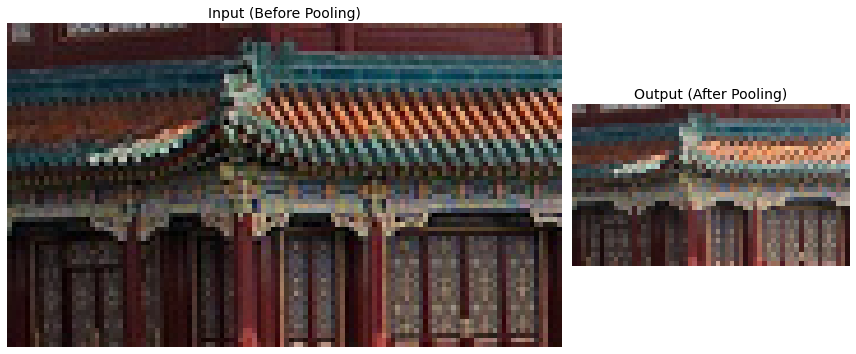

In [18]:
fig = plt.figure(figsize=(12,8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2,1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input (Before Pooling)", fontsize=14)
ax1.imshow(cropped_images[0]) # plot the 1st image // before max pooling
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output (After Pooling)", fontsize=14)
ax2.imshow(output[0]) # plot the output for the 1st image
ax2.axis("off")

save_fig("china_max_pooling")
plt.show()


## Average pooling

Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. 

In [19]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [20]:
output_avg = avg_pool(cropped_images)
output_avg.shape

TensorShape([2, 35, 60, 3])

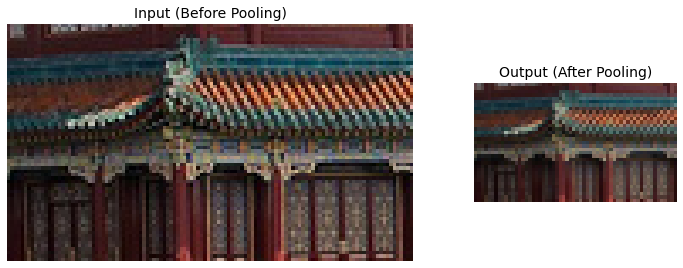

In [21]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input (Before Pooling)", fontsize=14) # plot the 1st image
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output (After Pooling)", fontsize=14) # Plot the output for the 1st image
ax2.imshow(output_avg[0])
ax2.axis("off")
plt.show();


## Global Average Pooling

All it does is compute the mean of each entire feature map. This means that it just outputs a single number per feature map and per instance. To create such a layer, simply use the `keras.layers.GlobalAvgPool2D` class:

In [22]:
cropped_images.shape

(2, 70, 120, 3)

In [23]:
global_avg_pool = keras.layers.GlobalAveragePooling2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [24]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

## Depth-wise pooling

Note that max pooling and average pooling can be performed along the depth dimension rather than the spatial dimensions, although this is not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern, such as hand- written digits, and the depth-wise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything else: thickness, brightness, skew, color, and so on. 

<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_10.png?raw=true" alt="Figure 14-7" width=500>

Keras does **not** include a depth-wise max pooling layer, but `TensorFlow`’s low-level Deep Learning API does: just use the `tf.nn.max_pool()` function, and **specify the kernel size and strides as 4-tuples**. The first three values of each should be 1: this indicates that the kernel size and stride along the batch, height, and width dimensions should be 1. The last value should be whatever kernel size and stride you want along the depth dimension—for example, 3 (**this must be a divisor of the input depth**; it will not work if the previous layer outputs 20 feature maps, since 20 is not a multiple of 3):

In [25]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size=None, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if pool_size is None:
            print("Do not forget to provide binary ndarray")
        if strides is None:
            strides = pool_size     

        self.pool_size = pool_size # reference that basically pool_size = depth
        self.strides = strides
        self.padding = padding  
        
    def call(self, inputs):
        try: # reference that basically pool_size = depth 
            if not self.pool_size:
                self.pool_size = inputs.shape[-1]
        except Exception as e:
            print(e)
        
        self.strides = self.pool_size
        
        return tf.nn.max_pool(inputs, 
                             ksize=(1, 1, 1, self.pool_size), 
                             strides=(1, 1, 1, self.pool_size),
                             padding=self.padding)

In [26]:
cropped_images.shape

(2, 70, 120, 3)

In [27]:
depth_pool = DepthMaxPool(3) #RGB channels
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

Or just use a `Lambda` layer:

In [28]:
depth_pool = keras.layers.Lambda(
                    lambda X: tf.nn.max_pool(X,
                                             ksize=(1, 1, 1, 3),
                                             strides=(1, 1, 1, 3),
                                             padding="VALID"))

with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

In [29]:
np.squeeze(depth_output[0], axis=-1).shape #= depth_output[0, ..., 0].shape

(70, 120)

In [30]:
cropped_images[0].shape

(70, 120, 3)

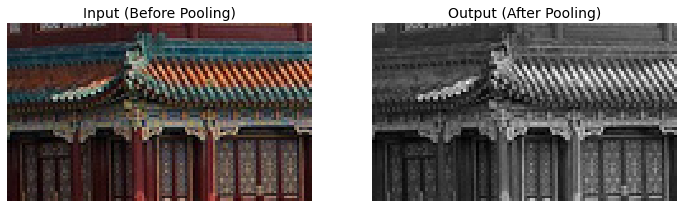

In [38]:
plt.figure(figsize=(12, 8))
plt.subplot(1,2,1)
plt.title("Input (Before Pooling)", fontsize=14)
plot_color_image(cropped_images[0]) # plot the 1st image

plt.subplot(1,2,2)
plt.title("Output (After Pooling)", fontsize=14)
plot_image(depth_output[0, ..., 0]) ## depth_output[0, ..., 0]  
                                    ## = np.squeeze(depth_output[0], axis=-1)

# Tackling Fashion MNIST With a CNN

Below is a typical `CNN architecture`:
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure14_11.png?raw=true" alt="Figure 14-7" width=600>

> A common mistake is to use convolution kernels that are too large. For example, instead of using a convolutional layer with a 5 × 5 kernel, it is generally preferable to stack two layers with 3 × 3 kernels: it will use less parameters and require less computations, and it will usually perform better. One exception to this recommendation is for the first convolutional layer: it can typically have a large kernel (e.g., 5 × 5), usually with stride of 2 or more: this will reduce the spatial dimension of the image without losing too much information, and since the input image only has 3 channels in general, it will not be too costly.

In [32]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

X_train.shape, X_valid.shape, X_test.shape

4431872/4422102 [==============================] - 0s 0us/step


((55000, 28, 28, 1), (5000, 28, 28, 1), (10000, 28, 28, 1))

In [33]:
y_train.shape, y_valid.shape, y_test.shape

((55000,), (5000,), (10000,))

In [34]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [35]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        3200      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 14, 14, 128)       73856     
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 7, 7, 128)        0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 7, 7, 256)         2

In [36]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)

X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 23s 11ms/step - loss: 0.7137 - accuracy: 0.7512 - val_loss: 0.3842 - val_accuracy: 0.8622
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4246 - accuracy: 0.8573 - val_loss: 0.3385 - val_accuracy: 0.8794
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3616 - accuracy: 0.8766 - val_loss: 0.3223 - val_accuracy: 0.8852
Epoch 4/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3362 - accuracy: 0.8864 - val_loss: 0.3127 - val_accuracy: 0.8906
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3079 - accuracy: 0.8949 - val_loss: 0.2984 - val_accuracy: 0.8958
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2871 - accuracy: 0.9024 - val_loss: 0.2866 - val_accuracy: 0.8918
Epoch 7/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.2799 - accuracy: 0.9050 - val_loss: 0.2715 - val_a

Saving figure keras_learning_curves_plot


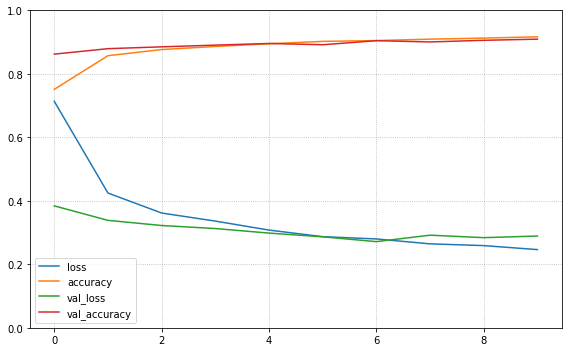

In [37]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.grid(linestyle=':')
save_fig("keras_learning_curves_plot")
plt.show()

## ResNet-34
When you initialize a regular neural network, its weights are close to zero, so the network just outputs values close to zero. If you add a skip connection, the resulting network just outputs a copy of its inputs; in other words, it initially models the identity function. If the target function is fairly close to the identity function (which is often the case), this will speed up training considerably. Moreover, if you add many skip connections, the network can start making progress even if several layers have not started learning yet. Thanks to skip connections, the signal can easily make its way across the whole network. The deep residual network can be seen as a stack of residual units (RUs), where each residual unit is a small neural network with a skip connection. 

`Residual learning`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure%2014_15.png?raw=true" alt="figure 14-15" width=500>

`Regular DNN (left) and deep residual network (right)`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure%2014_16.png?raw=true" alt="figure 14-15" width=500>

`ResNet architecture`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure%2014_17.png?raw=true" alt="figure 14-15" width=600>

`Skip connection when changing feature map size and depth`
<img src="https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure%2014_18.png?raw=true" alt="figure 14-15" width=500>

In [39]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1, 
                       padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation='relu', **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters), 
            keras.layers.BatchNormalization()
        ]
        self.skip_layers = []
        if strides > 1: # if stride is larger than 2, with 2d convol, reduce the dimension
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()
            ]
    
    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z) # if it's empty, do nothing; return empty
        return self.activation(Z + skip_Z)

In [40]:
model = keras.models.Sequential(name="ResNet-34")
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                       input_shape=(224, 224, 3)))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))

prev_filters=64
for filters in [64]*3 + [128]*4 + [256]*6 + [512]*3:
    strides=1 if filters==prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [41]:
model.summary()

Model: "ResNet-34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                         

## Using a Pretrained Model

In general, you won’t have to implement standard models like GoogLeNet or ResNet manually, since pretrained networks are readily available with a single line of code in the `keras.applications` package. For example, you can load the `ResNet-50` model, pretrained on ImageNet, with the following line of code: 

In [42]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

102981632/102967424 [==============================] - 0s 0us/step


In [43]:
images[0].shape

(427, 640, 3)

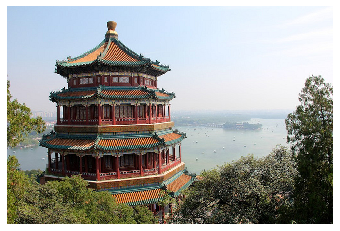

In [44]:
plot_color_image(images[0])

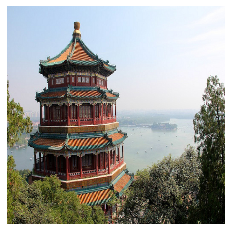

In [45]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

> The `tf.image.resize()` will not preserve the aspect ratio. If this is a problem, try cropping the images to the appropriate aspect ratio before resizing. Both operations can be done in one shot with `tf.image.crop_and_resize()`  

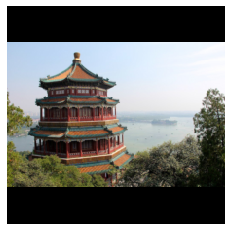

In [46]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

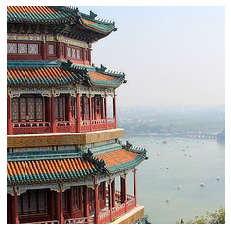

In [47]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

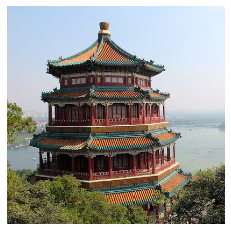

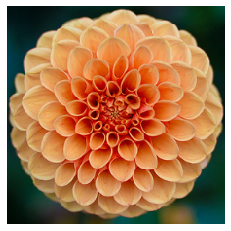

In [48]:
china_box = [0, 0.03, 1, 0.68] # [y1, x1, y2, x2]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

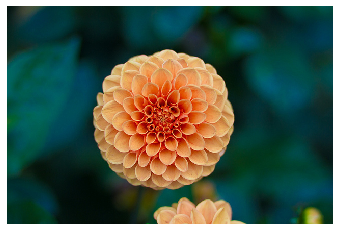

In [49]:
plot_color_image(images[1])

In [50]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [51]:
Y_proba.shape

(2, 1000)

In [52]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba * 100:.2f}%")
    print()

49152/35363 [=========================================] - 0s 0us/step
Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



## Pretrained Models for Transfer Learning
If you want to build an image classifier but you do not have enough training data, then it is often a good idea to reuse the lower layers of a pretrained model, as we discussed in Chapter 11 . For example, let’s train a model to classify pictures of flowers, reusing a pretrained Xception model. First, let’s load the dataset using TensorFlow Datasets.

In [72]:
import tensorflow_datasets as tfds

test_set_raw, valid_set_raw, train_set_raw  = tfds.load("tf_flowers", split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'], as_supervised=True)

Note that you can get information about the dataset by setting `with_info=True`. 

In [73]:
info.splits

{'train': <SplitInfo num_examples=3670, num_shards=2>}

In [74]:
info.splits["train"]

<SplitInfo num_examples=3670, num_shards=2>

In [75]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_path='~/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
)

In [76]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [77]:
n_classes = info.features["label"].num_classes

In [78]:
dataset_size = info.splits["train"].num_examples
dataset_size

3670

The `TF Datasets` project provides an API for spliting the data into test, valid, and training sets. 

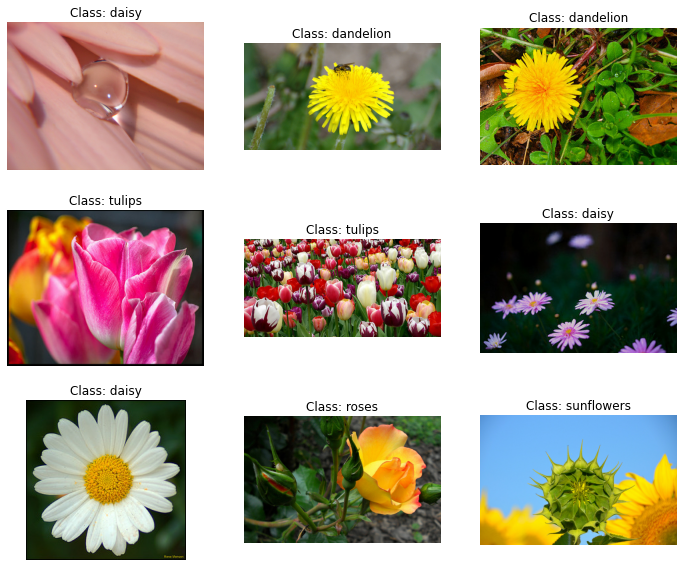

In [79]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()

The CNN expect 224 x 224 images, so we need to resize them. We also need to run the images through `Xception's preprocess_input()` function:

In [80]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but you could add much more data augmentation):

In [81]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

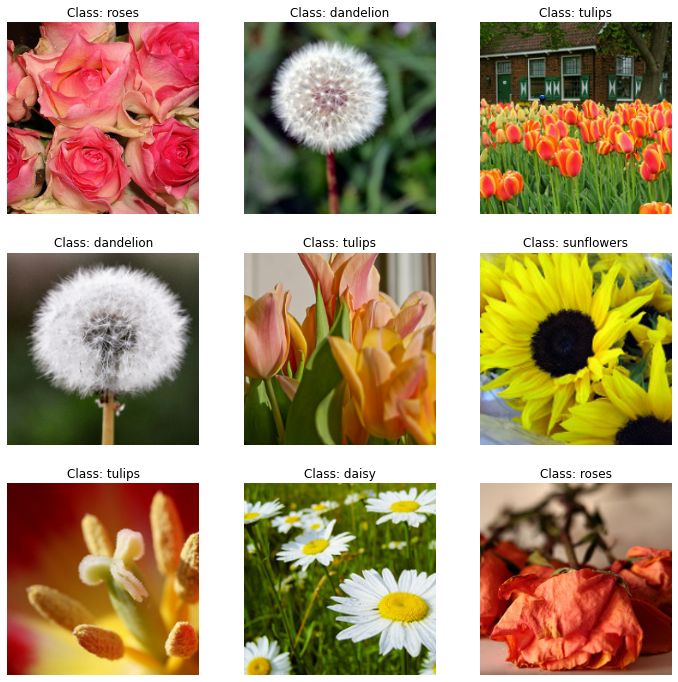

In [82]:
plt.figure(figsize=(12, 12))

for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

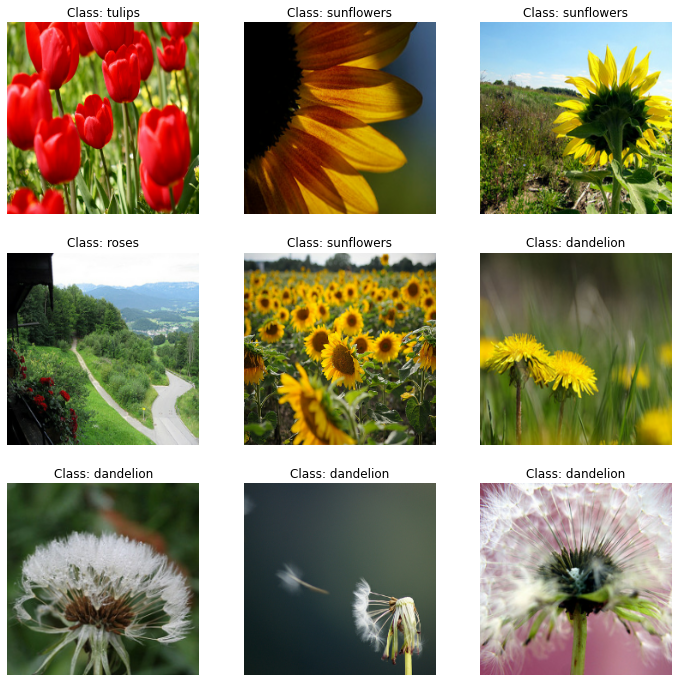

In [83]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [84]:
# We exclude the top of the network 
# this excludes the global average pooling layer and the dense output layer
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

83697664/83683744 [==============================] - 0s 0us/step


In [85]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_44
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_45
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_46
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

**It’s usually a good idea to freeze the weights of the pretrained layers, at least at the beginning of training**:

In [86]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])

history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


86/86 [==============================] - 19s 180ms/step - loss: 0.5150 - accuracy: 0.8739 - val_loss: 0.7535 - val_accuracy: 0.8676
Epoch 2/5
86/86 [==============================] - 15s 171ms/step - loss: 0.0745 - accuracy: 0.9778 - val_loss: 0.7566 - val_accuracy: 0.8493
Epoch 3/5
86/86 [==============================] - 14s 166ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.7041 - val_accuracy: 0.8676
Epoch 4/5
86/86 [==============================] - 14s 162ms/step - loss: 0.0205 - accuracy: 0.9931 - val_loss: 0.6698 - val_accuracy: 0.8640
Epoch 5/5
86/86 [==============================] - 14s 161ms/step - loss: 0.0180 - accuracy: 0.9942 - val_loss: 0.6505 - val_accuracy: 0.8695


In [89]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 64s 665ms/step - loss: 8.3967e-04 - accuracy: 1.0000 - val_loss: 0.5071 - val_accuracy: 0.9154
Epoch 2/5
86/86 [==============================] - 55s 641ms/step - loss: 0.0011 - accuracy: 0.9996 - val_loss: 0.5489 - val_accuracy: 0.9062
Epoch 3/5
86/86 [==============================] - 56s 647ms/step - loss: 8.4067e-04 - accuracy: 1.0000 - val_loss: 0.5094 - val_accuracy: 0.9136
Epoch 4/5
86/86 [==============================] - 56s 647ms/step - loss: 6.2666e-04 - accuracy: 1.0000 - val_loss: 0.4899 - val_accuracy: 0.9118
Epoch 5/5
86/86 [==============================] - 56s 653ms/step - loss: 4.9806e-04 - accuracy: 1.0000 - val_loss: 0.4819 - val_accuracy: 0.9099


# Classification and Localization

Localizing an object in a picture can be expressed as a regression task: to predict a bouding box around the object, a comman approach is to predict the horizontal and vertical coordinates of the object's center, as well as its height and widths. This means we have four numbers to predict. It does not require much change to the model; we just need to add a second dense output layer with four units (typically on top of the global average pooling layer), and it can be trained using the MSE loss:

In [90]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg) # difference here

model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output]) # two outputs now
model.compile(loss=["sparse_categorical_crossentropy", "mse"], # two evaluation metrics
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [91]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [92]:
fake_train_set

<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)))>

In [96]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 3s 605ms/step - loss: 1.0265 - dense_5_loss: 1.2434 - dense_6_loss: 0.1588 - dense_5_accuracy: 0.5938 - dense_6_accuracy: 0.2750
Epoch 2/2
5/5 [==============================] - 3s 624ms/step - loss: 0.8875 - dense_5_loss: 1.0635 - dense_6_loss: 0.1836 - dense_5_accuracy: 0.6875 - dense_6_accuracy: 0.2625


### Mean Average Precision (mAP)

In [94]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

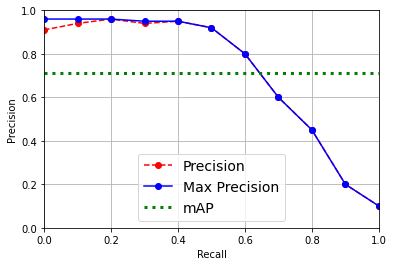

In [95]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

Transpose convolutions:
it is equivalent to first stretching the image by inserting empty rows and columns (full of zeros), then performing a regular convolution. The transposed convolutional layer can be initialized to perform something close to linear interpolation, but since it is a trainable layer, it will learn to do better during training. In tf.keras, you can use the Conv2DTranspose layer.

> In a transposed convolutional layer, the stride defines how much the input will be stretched, not the size of the filter steps, so the larger the stride, the larger the output (unlike for convolutional layers or pooling layers).

In [97]:
tf.random.set_seed(42)
X = images_resized.numpy()

print(X.shape)
conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

(2, 224, 224, 3)


TensorShape([2, 449, 449, 5])

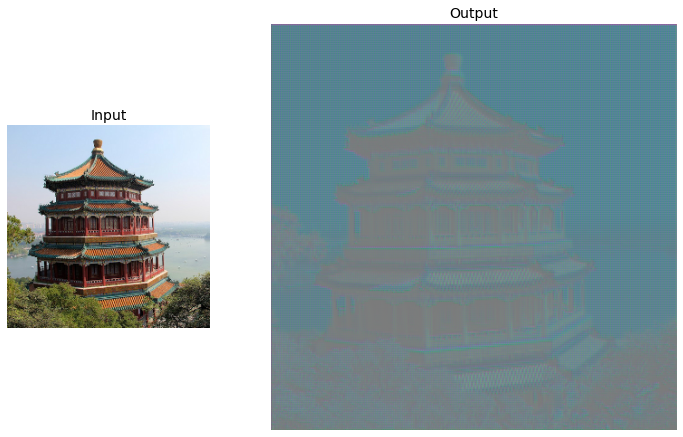

In [98]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [99]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [100]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

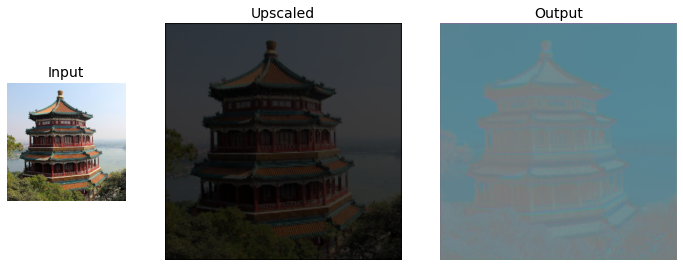

In [101]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [102]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

# Exercises

1. What are the advantages of a CNN over a fully connected DNN for image classification?

Fewer parameters -> faster to train
Reuse kernel -> detect feature anywhere
Architecture embeds knowledge of neighboring pixels

Because consecutive layers are only partially connected and because it heavily reuses its weights, a CNN has many fewer parameters than a fully connected DNN, which makes it much faster to train, reduces the risk of overfitting, and requires much less training data.

When a CNN has learned a kernel that can detect a particular feature, it can detect that feature anywhere on the image. In contrast, when a DNN learns a feature in one location, it can detect it only in that particular location. Since images typically have very repetitive features, CNNs are able to generalize much better than DNNs for image processing tasks such as classification, using fewer training examples.
Finally, a DNN has no prior knowledge of how pixels are organized; it does not know that nearby pixels are close. A CNN's architecture embeds this prior knowledge. Lower layers typically identify features in small areas of the images, while higher layers combine the lower-level features into larger features. This works well with most natural images, giving CNNs a decisive head start compared to DNNs.

2. If your GPU runs out of memory while training a CNN, what are five things you could try to solve the problem?

Reduce the mini-batch size.
Reduce dimensionality using a larger stride in one or more layers.
Remove one or more layers.
Use 16-bit floats instead of 32-bit floats.
Distribute the CNN across multiple devices

3. Why would you want to add a max pooling layer rather than a convolutional layer with the same stride?

A max pooling layer has no parameters at all, whereas a convolutional layer has a lot.

4. When would you want to add a local response normalization layer?

if we want to have wide vairety of feature for upper layers .

5. What is a Fully Convolutional Network? How can you convert a dense layer into
a convolutional layer?

is a neural network that only performs convolution (and subsampling or upsampling) operations. Equivalently, an FCN is a CNN without fully connected layers. we can coverti it  ust copy the weights from the dense layers to the convolutional layers!
Alternatively, we could have converted the CNN into an FCN before training.


6. High Accuracy CNN for MNIST
_Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST._

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the [MNIST Kaggle competition](https://www.kaggle.com/c/digit-recognizer/) (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in [this post](https://www.kaggle.com/c/digit-recognizer/discussion/61480)). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.

In [2]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 24s 6ms/step - loss: 0.1968 - accuracy: 0.9401 - val_loss: 0.0450 - val_accuracy: 0.9886
Epoch 2/10
1719/1719 [==============================] - 12s 7ms/step - loss: 0.0796 - accuracy: 0.9758 - val_loss: 0.0454 - val_accuracy: 0.9878
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0608 - accuracy: 0.9811 - val_loss: 0.0342 - val_accuracy: 0.9908
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0515 - accuracy: 0.9843 - val_loss: 0.0346 - val_accuracy: 0.9910
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0409 - accuracy: 0.9869 - val_loss: 0.0347 - val_accuracy: 0.9922
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0355 - accuracy: 0.9887 - val_loss: 0.0366 - val_accuracy: 0.9916
Epoch 7/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.0338 - accuracy: 0.9896 - val_loss: 0.0306 - val_ac

[0.030030474066734314, 0.9919999837875366]